In [ ]:
# ============================================================================
# SECTION 1: SETUP & INSTALLATION
# ============================================================================

# Install required packages
!pip install transformers datasets rouge-score nltk sentencepiece accelerate evaluate -q
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 -q

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    T5Tokenizer,
    T5ForConditionalGeneration,
    get_linear_schedule_with_warmup
)
from torch.optim import AdamW # Corrected import for AdamW
from datasets import Dataset as HFDataset
import evaluate
from nltk.tokenize import sent_tokenize
import nltk
import warnings
import time
import json
from tqdm.auto import tqdm

warnings.filterwarnings('ignore')
nltk.download('punkt', quiet=True)

# Set random seeds for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.4 MB/s eta 0:00:00
Using device: cuda
GPU: Tesla T4
Memory: 15.83 GB


In [ ]:
# ============================================================================
# SECTION 2: MOUNT GOOGLE DRIVE & LOAD DATA
# ============================================================================

# Mount Google Drive
drive.mount('/content/drive')

# Load dataset - MODIFY THIS PATH to your actual file path
DATA_PATH = '/content/drive/MyDrive/FINAL_ATI/arXiv_scientific dataset.csv'

print("Loading dataset...")
df = pd.read_csv(DATA_PATH)
print(f"Dataset loaded: {df.shape[0]} samples, {df.shape[1]} features")
print(f"\nColumns: {df.columns.tolist()}")
df.head()

Mounted at /content/drive
Loading dataset...
Dataset loaded: 136238 samples, 10 features

Columns: ['id', 'title', 'category', 'category_code', 'published_date', 'updated_date', 'authors', 'first_author', 'summary', 'summary_word_count']


,id,title,category,category_code,published_date,updated_date,authors,first_author,summary,summary_word_count
0,cs-9308101v1,Dynamic Backtracking,Artificial Intelligence,cs.AI,8/1/93,8/1/93,['M. L. Ginsberg'],'M. L. Ginsberg',Because of their occasional need to return to ...,79
1,cs-9308102v1,A Market-Oriented Programming Environment and ...,Artificial Intelligence,cs.AI,8/1/93,8/1/93,['M. P. Wellman'],'M. P. Wellman',Market price systems constitute a well-underst...,119
2,cs-9309101v1,An Empirical Analysis of Search in GSAT,Artificial Intelligence,cs.AI,9/1/93,9/1/93,"['I. P. Gent', 'T. Walsh']",'I. P. Gent',We describe an extensive study of search in GS...,167
3,cs-9311101v1,The Difficulties of Learning Logic Programs wi...,Artificial Intelligence,cs.AI,11/1/93,11/1/93,"['F. Bergadano', 'D. Gunetti', 'U. Trinchero']",'F. Bergadano',As real logic programmers normally use cut (!)...,174
4,cs-9311102v1,Software Agents: Completing Patterns and Const...,Artificial Intelligence,cs.AI,11/1/93,11/1/93,"['J. C. Schlimmer', 'L. A. Hermens']",'J. C. Schlimmer',To support the goal of allowing users to recor...,187



EXPLORATORY DATA ANALYSIS

1. Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136238 entries, 0 to 136237
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   id                  136238 non-null  object
 1   title               136238 non-null  object
 2   category            136238 non-null  object
 3   category_code       136238 non-null  object
 4   published_date      136238 non-null  object
 5   updated_date        136238 non-null  object
 6   authors             136238 non-null  object
 7   first_author        136238 non-null  object
 8   summary             136238 non-null  object
 9   summary_word_count  136238 non-null  int64 
dtypes: int64(1), object(9)
memory usage: 10.4+ MB
None

2. Missing Values:
id                    0
title                 0
category              0
category_code         0
published_date        0
updated_date          0
authors               0
first_author

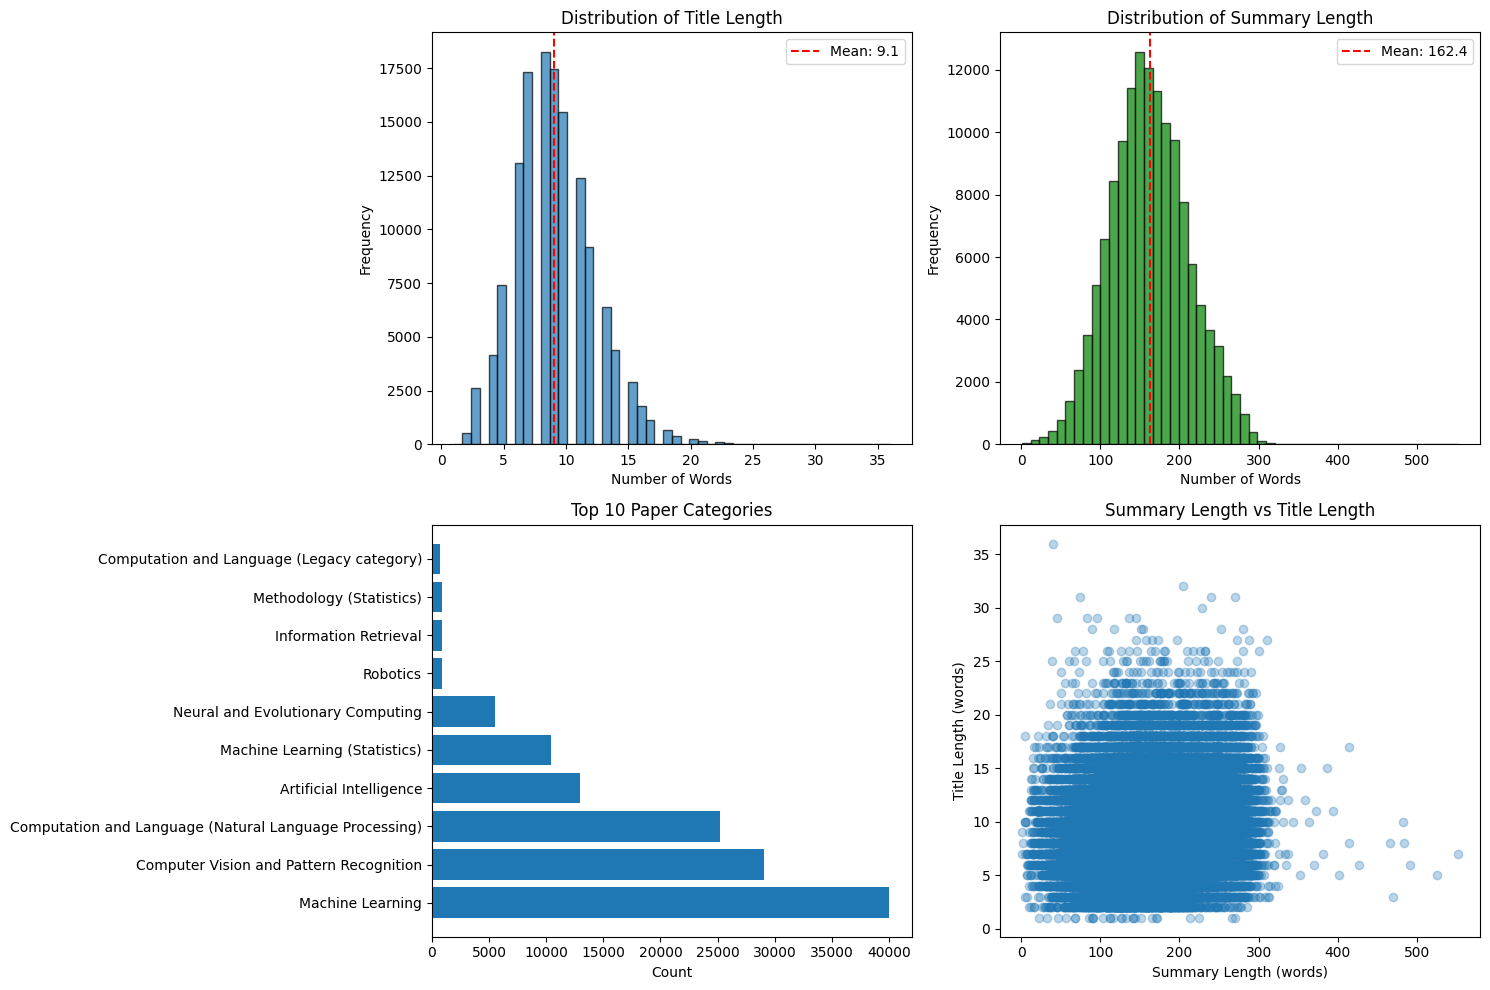


5. Sample Papers:

--- Example 1 ---
Title: Dynamic Backtracking
Summary (first 200 chars): Because of their occasional need to return to shallow points in a search
tree, existing backtracking methods can sometimes erase meaningful progress
toward solving a search problem. In this paper, we ...
Category: Artificial Intelligence

--- Example 2 ---
Title: A Market-Oriented Programming Environment and its Application to
  Distributed Multicommodity Flow Problems
Summary (first 200 chars): Market price systems constitute a well-understood class of mechanisms that
under certain conditions provide effective decentralization of decision making
with minimal communication overhead. In a mark...
Category: Artificial Intelligence

--- Example 3 ---
Title: An Empirical Analysis of Search in GSAT
Summary (first 200 chars): We describe an extensive study of search in GSAT, an approximation procedure
for propositional satisfiability. GSAT performs greedy hill-climbing on the
number of satisfied clau

In [ ]:
# ============================================================================
# SECTION 3: EXPLORATORY DATA ANALYSIS (EDA)
# ============================================================================

print("\n" + "="*80)
print("EXPLORATORY DATA ANALYSIS")
print("="*80)

# Basic statistics
print("\n1. Dataset Info:")
print(df.info())

print("\n2. Missing Values:")
print(df.isnull().sum())

print("\n3. Basic Statistics:")
print(df.describe())

# Title length analysis
df['title_length'] = df['title'].str.split().str.len()
df['summary_length'] = df['summary'].str.split().str.len()

print(f"\n4. Length Analysis:")
print(f"Title length - Mean: {df['title_length'].mean():.1f}, Median: {df['title_length'].median():.1f}")
print(f"Summary length - Mean: {df['summary_length'].mean():.1f}, Median: {df['summary_length'].median():.1f}")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Title length distribution
axes[0, 0].hist(df['title_length'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Number of Words')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Title Length')
axes[0, 0].axvline(df['title_length'].mean(), color='red', linestyle='--', label=f'Mean: {df["title_length"].mean():.1f}')
axes[0, 0].legend()

# Plot 2: Summary length distribution
axes[0, 1].hist(df['summary_length'], bins=50, edgecolor='black', alpha=0.7, color='green')
axes[0, 1].set_xlabel('Number of Words')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Summary Length')
axes[0, 1].axvline(df['summary_length'].mean(), color='red', linestyle='--', label=f'Mean: {df["summary_length"].mean():.1f}')
axes[0, 1].legend()

# Plot 3: Top categories
if 'category' in df.columns:
    top_categories = df['category'].value_counts().head(10)
    axes[1, 0].barh(range(len(top_categories)), top_categories.values)
    axes[1, 0].set_yticks(range(len(top_categories)))
    axes[1, 0].set_yticklabels(top_categories.index)
    axes[1, 0].set_xlabel('Count')
    axes[1, 0].set_title('Top 10 Paper Categories')

# Plot 4: Scatter plot - summary vs title length
axes[1, 1].scatter(df['summary_length'], df['title_length'], alpha=0.3)
axes[1, 1].set_xlabel('Summary Length (words)')
axes[1, 1].set_ylabel('Title Length (words)')
axes[1, 1].set_title('Summary Length vs Title Length')

plt.tight_layout()
plt.show()

# Sample examples
print("\n5. Sample Papers:")
for i in range(3):
    print(f"\n--- Example {i+1} ---")
    print(f"Title: {df.iloc[i]['title']}")
    print(f"Summary (first 200 chars): {df.iloc[i]['summary'][:200]}...")
    print(f"Category: {df.iloc[i].get('category', 'N/A')}")

In [ ]:
# ============================================================================
# SECTION 4: DATA PREPROCESSING (EMERGENCY FIX)
# ============================================================================

print("\n" + "="*80)
print("DATA PREPROCESSING (REDUCED VERSION)")
print("="*80)

# 1. Clean data function
def clean_text(text):
    if pd.isna(text): return ""
    text = str(text).strip()
    text = ' '.join(text.split())
    return text

df['summary_clean'] = df['summary'].apply(clean_text)
df['title_clean'] = df['title'].apply(clean_text)

# 2. Lọc rác
df = df[(df['summary_clean'].str.len() > 10) & (df['title_clean'].str.len() > 3)]


TARGET_SIZE = 30000

if len(df) > TARGET_SIZE:
    print(f"Dataset gốc quá lớn ({len(df)}).")
    print(f"Đang lấy mẫu ngẫu nhiên {TARGET_SIZE} dòng để train nhanh.")
    df = df.sample(n=TARGET_SIZE, random_state=42)
else:
    print(f"Dataset nhỏ ({len(df)}), giữ nguyên.")

# 3. Chia tập train/val/test
from sklearn.model_selection import train_test_split
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"\nDataset split (Final):")
print(f"Training: {len(train_df)} samples")
print(f"Validation: {len(val_df)} samples")
print(f"Test: {len(test_df)} samples")


DATA PREPROCESSING (REDUCED VERSION)
Dataset gốc quá lớn (136236).
Đang lấy mẫu ngẫu nhiên 30000 dòng để train nhanh.

Dataset split (Final):
Training: 24000 samples
Validation: 3000 samples
Test: 3000 samples


In [ ]:
# ============================================================================
# SECTION 5: TOKENIZATION & DATASET PREPARATION
# ============================================================================

print("\n" + "="*80)
print("TOKENIZATION & DATASET PREPARATION")
print("="*80)

# Load T5 tokenizer
MODEL_NAME = 't5-small'
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

# Hyperparameters
MAX_SOURCE_LENGTH = 256
MAX_TARGET_LENGTH = 64
BATCH_SIZE = 8
GRADIENT_ACCUMULATION_STEPS = 4

print(f"Model: {MODEL_NAME}")
print(f"Max source length: {MAX_SOURCE_LENGTH}")
print(f"Max target length: {MAX_TARGET_LENGTH}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Gradient accumulation steps: {GRADIENT_ACCUMULATION_STEPS}")
print(f"Effective batch size: {BATCH_SIZE * GRADIENT_ACCUMULATION_STEPS}")

# Custom Dataset class
class TitleGenerationDataset(Dataset):
    def __init__(self, dataframe, tokenizer, source_len, target_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.source_len = source_len
        self.target_len = target_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        # T5 requires task prefix
        source_text = "summarize: " + row['summary_clean']
        target_text = row['title_clean']

        # Tokenize source
        source = self.tokenizer(
            source_text,
            max_length=self.source_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Tokenize target
        target = self.tokenizer(
            target_text,
            max_length=self.target_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': source['input_ids'].squeeze(),
            'attention_mask': source['attention_mask'].squeeze(),
            'labels': target['input_ids'].squeeze()
        }

# Create datasets
train_dataset = TitleGenerationDataset(train_df, tokenizer, MAX_SOURCE_LENGTH, MAX_TARGET_LENGTH)
val_dataset = TitleGenerationDataset(val_df, tokenizer, MAX_SOURCE_LENGTH, MAX_TARGET_LENGTH)
test_dataset = TitleGenerationDataset(test_df, tokenizer, MAX_SOURCE_LENGTH, MAX_TARGET_LENGTH)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"\nDataLoaders created:")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")



TOKENIZATION & DATASET PREPARATION


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Model: t5-small
Max source length: 256
Max target length: 64
Batch size: 8
Gradient accumulation steps: 4
Effective batch size: 32

DataLoaders created:
Train batches: 3000
Val batches: 375
Test batches: 375


In [ ]:
# ============================================================================
# SECTION 6: MODEL ARCHITECTURE & OPTIMIZATION TECHNIQUES
# ============================================================================

print("\n" + "="*80)
print("MODEL ARCHITECTURE & OPTIMIZATION TECHNIQUES")
print("="*80)

"""
OPTIMIZATION TECHNIQUES APPLIED:

1. LEARNING RATE SCHEDULING WITH WARMUP
   - Linear warmup for stable training start
   - Gradual decay to prevent overshooting
   - Improves convergence and final performance

2. GRADIENT ACCUMULATION
   - Simulate larger batch sizes without memory constraints
   - More stable gradient estimates
   - Better generalization

3. EARLY STOPPING
   - Monitor validation loss
   - Prevent overfitting
   - Save best model checkpoint

4. MIXED PRECISION TRAINING (FP16)
   - Faster training with less memory
   - Maintains model accuracy
   - Utilizes Tensor Cores on modern GPUs
"""

# Load pre-trained T5 model
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)
model = model.to(device)

print(f"\nModel loaded: {MODEL_NAME}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Training hyperparameters
LEARNING_RATE = 5e-5
NUM_EPOCHS = 15
WARMUP_STEPS = 500
WEIGHT_DECAY = 0.01
EARLY_STOPPING_PATIENCE = 3

print(f"\nTraining Configuration:")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Epochs: {NUM_EPOCHS}")
print(f"Warmup steps: {WARMUP_STEPS}")
print(f"Weight decay: {WEIGHT_DECAY}")
print(f"Early stopping patience: {EARLY_STOPPING_PATIENCE}")

# OPTIMIZATION TECHNIQUE 1: AdamW optimizer with weight decay
optimizer = AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    betas=(0.9, 0.999),
    eps=1e-8
)

# Calculate total training steps
total_steps = len(train_loader) * NUM_EPOCHS // GRADIENT_ACCUMULATION_STEPS

# OPTIMIZATION TECHNIQUE 2: Learning rate scheduler with warmup
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=WARMUP_STEPS,
    num_training_steps=total_steps
)

print(f"Total training steps: {total_steps}")
print(f"Warmup steps: {WARMUP_STEPS}")

# Mixed precision training scaler
scaler = torch.cuda.amp.GradScaler()


MODEL ARCHITECTURE & OPTIMIZATION TECHNIQUES


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]


Model loaded: t5-small
Total parameters: 60,506,624
Trainable parameters: 60,506,624

Training Configuration:
Learning rate: 5e-05
Epochs: 15
Warmup steps: 500
Weight decay: 0.01
Early stopping patience: 3
Total training steps: 11250
Warmup steps: 500


In [ ]:
# ============================================================================
# SECTION 7: TRAINING LOOP WITH OPTIMIZATION
# ============================================================================

print("\n" + "="*80)
print("TRAINING")
print("="*80)

def train_epoch(model, dataloader, optimizer, scheduler, scaler, device, accumulation_steps):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    progress_bar = tqdm(dataloader, desc="Training")

    optimizer.zero_grad()

    for i, batch in enumerate(progress_bar):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Mixed precision training
        with torch.cuda.amp.autocast():
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = outputs.loss
            # Normalize loss for gradient accumulation
            loss = loss / accumulation_steps

        # Backward pass with gradient scaling
        scaler.scale(loss).backward()

        # Gradient accumulation
        if (i + 1) % accumulation_steps == 0:
            # Gradient clipping
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            # Optimizer step
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            optimizer.zero_grad()

        total_loss += loss.item() * accumulation_steps
        progress_bar.set_postfix({'loss': loss.item() * accumulation_steps})

    return total_loss / len(dataloader)

def validate(model, dataloader, device):
    """Validate the model"""
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validation"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = outputs.loss
            total_loss += loss.item()

    return total_loss / len(dataloader)

# Training history
history = {
    'train_loss': [],
    'val_loss': [],
    'learning_rate': []
}

# Early stopping variables
best_val_loss = float('inf')
patience_counter = 0
best_model_path = '/content/drive/MyDrive/best_model_t5.pt'

# Training loop
print("\nStarting training...")
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    print(f"\n{'='*80}")
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS}")
    print(f"{'='*80}")

    # Train
    train_loss = train_epoch(
        model, train_loader, optimizer, scheduler,
        scaler, device, GRADIENT_ACCUMULATION_STEPS
    )

    # Validate
    val_loss = validate(model, val_loader, device)

    # Get current learning rate
    current_lr = scheduler.get_last_lr()[0]

    # Save history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['learning_rate'].append(current_lr)

    print(f"\nEpoch {epoch + 1} Results:")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}")
    print(f"Learning Rate: {current_lr:.2e}")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), best_model_path)
        print(f"✓ Best model saved! Val Loss: {val_loss:.4f}")
    else:
        patience_counter += 1
        print(f"⚠ No improvement. Patience: {patience_counter}/{EARLY_STOPPING_PATIENCE}")

        if patience_counter >= EARLY_STOPPING_PATIENCE:
            print("\n⚠ Early stopping triggered!")
            break

training_time = time.time() - start_time
print(f"\n{'='*80}")
print(f"Training completed in {training_time/60:.2f} minutes")
print(f"Best validation loss: {best_val_loss:.4f}")

# Load best model
model.load_state_dict(torch.load(best_model_path))
print("Best model loaded for evaluation")


TRAINING

Starting training...

Epoch 1/15


Training:   0%|          | 0/3000 [00:00<?, ?it/s]

Validation:   0%|          | 0/375 [00:00<?, ?it/s]


Epoch 1 Results:
Train Loss: 2.5139
Val Loss: 0.6426
Learning Rate: 4.88e-05
✓ Best model saved! Val Loss: 0.6426

Epoch 2/15


Training:   0%|          | 0/3000 [00:00<?, ?it/s]

Validation:   0%|          | 0/375 [00:00<?, ?it/s]


Epoch 2 Results:
Train Loss: 0.6874
Val Loss: 0.6153
Learning Rate: 4.53e-05
✓ Best model saved! Val Loss: 0.6153

Epoch 3/15


Training:   0%|          | 0/3000 [00:00<?, ?it/s]

Validation:   0%|          | 0/375 [00:00<?, ?it/s]


Epoch 3 Results:
Train Loss: 0.6556
Val Loss: 0.5999
Learning Rate: 4.19e-05
✓ Best model saved! Val Loss: 0.5999

Epoch 4/15


Training:   0%|          | 0/3000 [00:00<?, ?it/s]

Validation:   0%|          | 0/375 [00:00<?, ?it/s]


Epoch 4 Results:
Train Loss: 0.6369
Val Loss: 0.5909
Learning Rate: 3.84e-05
✓ Best model saved! Val Loss: 0.5909

Epoch 5/15


Training:   0%|          | 0/3000 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a6028df4220>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    Exception ignored in: self._shutdown_workers()
<function _MultiProcessingDataLoaderIter.__del__ at 0x7a6028df4220>  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers

    Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
if w.is_alive():
     self._shutdown_workers() 
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
       if w.is_alive(): 
 ^ ^^  ^  ^ ^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
 ^ ^ ^ 
   File "/usr/lib/p

Validation:   0%|          | 0/375 [00:00<?, ?it/s]


Epoch 5 Results:
Train Loss: 0.6234
Val Loss: 0.5847
Learning Rate: 3.49e-05
✓ Best model saved! Val Loss: 0.5847

Epoch 6/15


Training:   0%|          | 0/3000 [00:00<?, ?it/s]

Validation:   0%|          | 0/375 [00:00<?, ?it/s]


Epoch 6 Results:
Train Loss: 0.6118
Val Loss: 0.5781
Learning Rate: 3.14e-05
✓ Best model saved! Val Loss: 0.5781

Epoch 7/15


Training:   0%|          | 0/3000 [00:00<?, ?it/s]

Validation:   0%|          | 0/375 [00:00<?, ?it/s]


Epoch 7 Results:
Train Loss: 0.6025
Val Loss: 0.5756
Learning Rate: 2.79e-05
✓ Best model saved! Val Loss: 0.5756

Epoch 8/15


Training:   0%|          | 0/3000 [00:00<?, ?it/s]

Validation:   0%|          | 0/375 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a6028df4220>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
    Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7a6028df4220>
  Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^    ^^^^if w.is_alive():
^ ^ ^ 
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
      assert self._parent_pid == os.getpid(), 'can only test a child process'  
^ ^  ^^ ^  ^ ^ ^ ^ ^^ ^
^^  File "/u


Epoch 8 Results:
Train Loss: 0.5950
Val Loss: 0.5717
Learning Rate: 2.44e-05
✓ Best model saved! Val Loss: 0.5717

Epoch 9/15


Training:   0%|          | 0/3000 [00:00<?, ?it/s]

Validation:   0%|          | 0/375 [00:00<?, ?it/s]


Epoch 9 Results:
Train Loss: 0.5887
Val Loss: 0.5706
Learning Rate: 2.09e-05
✓ Best model saved! Val Loss: 0.5706

Epoch 10/15


Training:   0%|          | 0/3000 [00:00<?, ?it/s]

Validation:   0%|          | 0/375 [00:00<?, ?it/s]


Epoch 10 Results:
Train Loss: 0.5834
Val Loss: 0.5671
Learning Rate: 1.74e-05
✓ Best model saved! Val Loss: 0.5671

Epoch 11/15


Training:   0%|          | 0/3000 [00:00<?, ?it/s]

Validation:   0%|          | 0/375 [00:00<?, ?it/s]


Epoch 11 Results:
Train Loss: 0.5794
Val Loss: 0.5672
Learning Rate: 1.40e-05
⚠ No improvement. Patience: 1/3

Epoch 12/15


Training:   0%|          | 0/3000 [00:00<?, ?it/s]

Validation:   0%|          | 0/375 [00:00<?, ?it/s]

Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7a6028df4220>
Exception ignored in: Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7a6028df4220>    self._shutdown_workers()

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
Traceback (most recent call last):
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
if w.is_alive():    
self._shutdown_workers()  
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
       if w.is_alive(): 
  ^ ^ ^ ^ ^ ^^ ^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^^assert self._parent_pid == os.getpid(), 'can only test a child process'
^ ^ ^
   File "/usr/lib/py


Epoch 12 Results:
Train Loss: 0.5756
Val Loss: 0.5667
Learning Rate: 1.05e-05
✓ Best model saved! Val Loss: 0.5667

Epoch 13/15


Training:   0%|          | 0/3000 [00:00<?, ?it/s]

Validation:   0%|          | 0/375 [00:00<?, ?it/s]


Epoch 13 Results:
Train Loss: 0.5733
Val Loss: 0.5658
Learning Rate: 6.98e-06
✓ Best model saved! Val Loss: 0.5658

Epoch 14/15


Training:   0%|          | 0/3000 [00:00<?, ?it/s]

Validation:   0%|          | 0/375 [00:00<?, ?it/s]


Epoch 14 Results:
Train Loss: 0.5718
Val Loss: 0.5652
Learning Rate: 3.49e-06
✓ Best model saved! Val Loss: 0.5652

Epoch 15/15


Training:   0%|          | 0/3000 [00:00<?, ?it/s]

Validation:   0%|          | 0/375 [00:00<?, ?it/s]


Epoch 15 Results:
Train Loss: 0.5701
Val Loss: 0.5649
Learning Rate: 0.00e+00
✓ Best model saved! Val Loss: 0.5649

Training completed in 89.92 minutes
Best validation loss: 0.5649
Best model loaded for evaluation



TRAINING VISUALIZATION


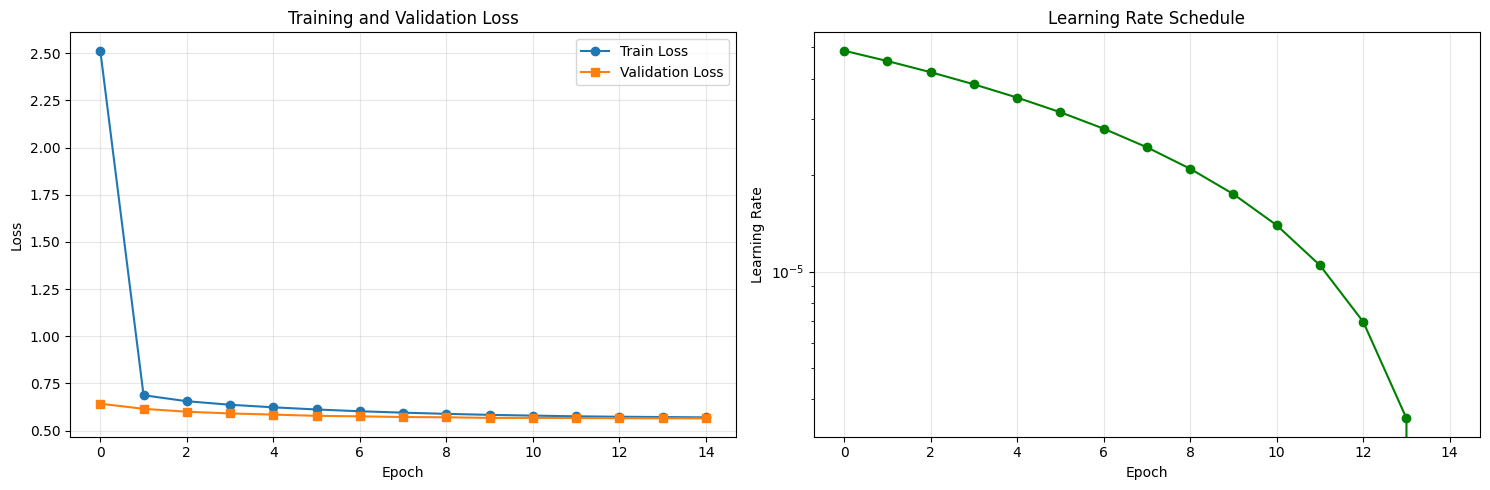

In [ ]:
# ============================================================================
# SECTION 8: PLOT TRAINING HISTORY
# ============================================================================

print("\n" + "="*80)
print("TRAINING VISUALIZATION")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot loss
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Validation Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot learning rate
axes[1].plot(history['learning_rate'], marker='o', color='green')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Learning Rate')
axes[1].set_title('Learning Rate Schedule')
axes[1].grid(True, alpha=0.3)
axes[1].set_yscale('log')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/training_history.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# ============================================================================
# SECTION 9: EVALUATION METRICS (ROUGE & BLEU)
# ============================================================================

print("\n" + "="*80)
print("EVALUATION")
print("="*80)

# Load evaluation metrics
rouge_metric = evaluate.load('rouge')
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def generate_title(model, tokenizer, summary, device, max_length=64):
    """Generate title from summary"""
    model.eval()

    # Prepare input
    input_text = "summarize: " + summary
    inputs = tokenizer(
        input_text,
        max_length=MAX_SOURCE_LENGTH,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    # Generate
    with torch.no_grad():
        outputs = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=max_length,
            num_beams=5,  # Beam search for better quality
            early_stopping=True,
            no_repeat_ngram_size=2,
            length_penalty=1.0
        )

    # Decode
    generated_title = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return generated_title

def evaluate_model(model, tokenizer, dataframe, device, num_samples=None):
    """Evaluate model on dataset"""
    if num_samples:
        dataframe = dataframe.head(num_samples)

    predictions = []
    references = []

    print(f"Generating predictions for {len(dataframe)} samples...")

    for idx, row in tqdm(dataframe.iterrows(), total=len(dataframe)):
        summary = row['summary_clean']
        true_title = row['title_clean']

        # Generate prediction
        pred_title = generate_title(model, tokenizer, summary, device)

        predictions.append(pred_title)
        references.append(true_title)

    return predictions, references

# Evaluate on test set
print("\nEvaluating on test set...")
predictions, references = evaluate_model(
    model, tokenizer, test_df, device, num_samples=None
)

# Calculate ROUGE scores
print("\nCalculating ROUGE scores...")
rouge_results = rouge_metric.compute(
    predictions=predictions,
    references=references,
    use_stemmer=True
)

print("\n" + "="*60)
print("ROUGE SCORES")
print("="*60)
for key, value in rouge_results.items():
    print(f"{key.upper()}: {value:.4f}")

# Calculate BLEU scores
print("\nCalculating BLEU scores...")
smoothing = SmoothingFunction().method1
bleu_scores = []

for pred, ref in zip(predictions, references):
    pred_tokens = pred.split()
    ref_tokens = [ref.split()]
    score = sentence_bleu(ref_tokens, pred_tokens, smoothing_function=smoothing)
    bleu_scores.append(score)

avg_bleu = np.mean(bleu_scores)
print("\n" + "="*60)
print("BLEU SCORES")
print("="*60)
print(f"Average BLEU: {avg_bleu:.4f}")
print(f"BLEU std: {np.std(bleu_scores):.4f}")


EVALUATION



Evaluating on test set...
Generating predictions for 3000 samples...


  0%|          | 0/3000 [00:00<?, ?it/s]


Calculating ROUGE scores...

ROUGE SCORES
ROUGE1: 0.4731
ROUGE2: 0.2845
ROUGEL: 0.4237
ROUGELSUM: 0.4238

Calculating BLEU scores...

BLEU SCORES
Average BLEU: 0.1208
BLEU std: 0.1882


In [ ]:
# ============================================================================
# SECTION 10: QUALITATIVE ANALYSIS - SAMPLE PREDICTIONS
# ============================================================================

print("\n" + "="*80)
print("SAMPLE PREDICTIONS")
print("="*80)

# Show sample predictions
num_samples_to_show = 10
sample_indices = np.random.choice(len(test_df), num_samples_to_show, replace=False)

print(f"\nShowing {num_samples_to_show} random samples:\n")

for i, idx in enumerate(sample_indices):
    row = test_df.iloc[idx]
    summary = row['summary_clean']
    true_title = row['title_clean']
    pred_title = predictions[idx]

    print(f"\n{'='*80}")
    print(f"Sample {i+1}:")
    print(f"{'='*80}")
    print(f"\nSummary (first 200 chars):\n{summary[:200]}...")
    print(f"\n✓ TRUE TITLE:\n{true_title}")
    print(f"\n✓ PREDICTED TITLE:\n{pred_title}")

    # Calculate individual ROUGE score
    rouge_score = rouge_metric.compute(
        predictions=[pred_title],
        references=[true_title],
        use_stemmer=True
    )
    print(f"\nROUGE-1: {rouge_score['rouge1']:.4f}")
    print(f"ROUGE-L: {rouge_score['rougeL']:.4f}")


SAMPLE PREDICTIONS

Showing 10 random samples:


Sample 1:

Summary (first 200 chars):
In this work, we explore modeling change points in time-series data using neural stochastic differential equations (neural SDEs). We propose a novel model formulation and training procedure based on t...

✓ TRUE TITLE:
Variational Neural Stochastic Differential Equations with Change Points

✓ PREDICTED TITLE:
Modeling Change Points in Time-Series Data using Neural Stochastic Differential Equations

ROUGE-1: 0.6000
ROUGE-L: 0.4000

Sample 2:

Summary (first 200 chars):
Several `edge-discovery' applications over graph-based data models are known to have worst-case quadratic time complexity in the nodes, even if the discovered edges are sparse. One example is the gene...

✓ TRUE TITLE:
Adaptive Candidate Generation for Scalable Edge-discovery Tasks on Data Graphs

✓ PREDICTED TITLE:
Disjunctive Normal Form Blocking Schemes

ROUGE-1: 0.0000
ROUGE-L: 0.0000

Sample 3:

Summary (first 200 chars):
In this 


ERROR ANALYSIS

Title Length Analysis:
Average predicted length: 7.20 words
Average true length: 9.06 words
Average length difference: 2.94 words

Performance Distribution (by ROUGE-L):
Excellent (≥0.5): 1088 samples (36.3%)
Good (0.3-0.5): 931 samples (31.0%)
Fair (0.15-0.3): 640 samples (21.3%)
Poor (<0.15): 341 samples (11.4%)


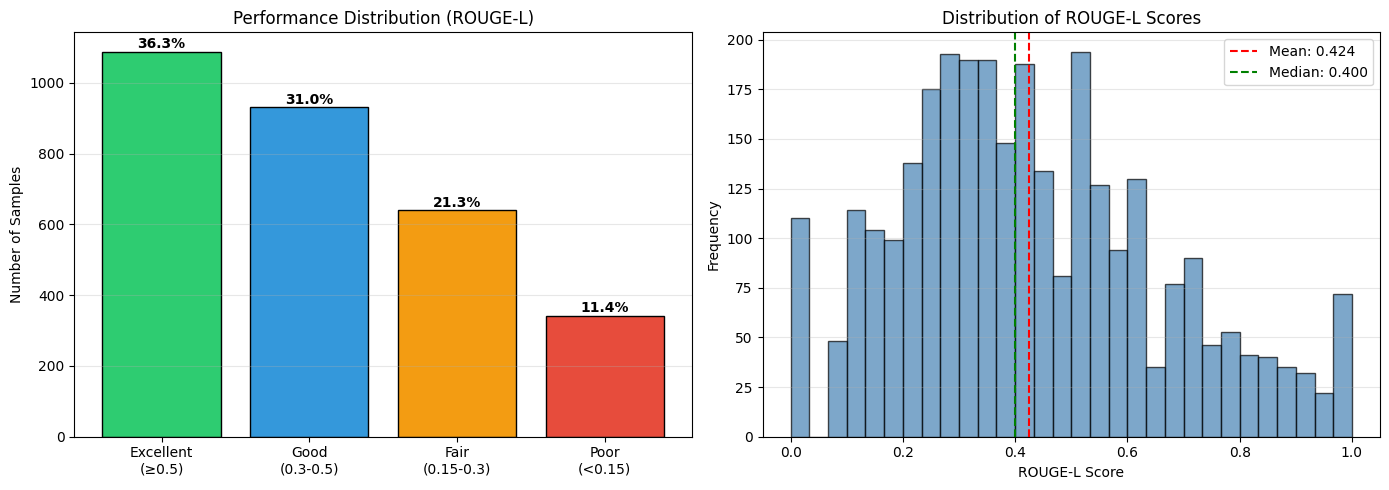

In [ ]:
# ============================================================================
# SECTION 11: CONFUSION MATRIX ALTERNATIVE - ERROR ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("ERROR ANALYSIS")
print("="*80)

# Since this is a generation task, not classification, we analyze errors differently

# Calculate title length differences
pred_lengths = [len(p.split()) for p in predictions]
true_lengths = [len(r.split()) for r in references]
length_diffs = [abs(p - t) for p, t in zip(pred_lengths, true_lengths)]

print("\nTitle Length Analysis:")
print(f"Average predicted length: {np.mean(pred_lengths):.2f} words")
print(f"Average true length: {np.mean(true_lengths):.2f} words")
print(f"Average length difference: {np.mean(length_diffs):.2f} words")

# Categorize performance by ROUGE-L score
rouge_l_scores = []
for pred, ref in zip(predictions, references):
    score = rouge_metric.compute(
        predictions=[pred],
        references=[ref],
        use_stemmer=True
    )['rougeL']
    rouge_l_scores.append(score)

rouge_l_scores = np.array(rouge_l_scores)

# Performance categories
excellent = np.sum(rouge_l_scores >= 0.5)
good = np.sum((rouge_l_scores >= 0.3) & (rouge_l_scores < 0.5))
fair = np.sum((rouge_l_scores >= 0.15) & (rouge_l_scores < 0.3))
poor = np.sum(rouge_l_scores < 0.15)

print("\nPerformance Distribution (by ROUGE-L):")
print(f"Excellent (≥0.5): {excellent} samples ({excellent/len(rouge_l_scores)*100:.1f}%)")
print(f"Good (0.3-0.5): {good} samples ({good/len(rouge_l_scores)*100:.1f}%)")
print(f"Fair (0.15-0.3): {fair} samples ({fair/len(rouge_l_scores)*100:.1f}%)")
print(f"Poor (<0.15): {poor} samples ({poor/len(rouge_l_scores)*100:.1f}%)")

# Visualize performance distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Performance categories
categories = ['Excellent\n(≥0.5)', 'Good\n(0.3-0.5)', 'Fair\n(0.15-0.3)', 'Poor\n(<0.15)']
counts = [excellent, good, fair, poor]
colors = ['#2ecc71', '#3498db', '#f39c12', '#e74c3c']
axes[0].bar(categories, counts, color=colors, edgecolor='black')
axes[0].set_ylabel('Number of Samples')
axes[0].set_title('Performance Distribution (ROUGE-L)')
axes[0].grid(axis='y', alpha=0.3)

# Add percentage labels on bars
for i, (cat, count) in enumerate(zip(categories, counts)):
    percentage = count / len(rouge_l_scores) * 100
    axes[0].text(i, count + 10, f'{percentage:.1f}%', ha='center', fontweight='bold')

# Plot 2: ROUGE-L distribution histogram
axes[1].hist(rouge_l_scores, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[1].axvline(np.mean(rouge_l_scores), color='red', linestyle='--',
                label=f'Mean: {np.mean(rouge_l_scores):.3f}')
axes[1].axvline(np.median(rouge_l_scores), color='green', linestyle='--',
                label=f'Median: {np.median(rouge_l_scores):.3f}')
axes[1].set_xlabel('ROUGE-L Score')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of ROUGE-L Scores')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/performance_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# ============================================================================
# SECTION 12: INFERENCE ON NEW DATA
# ============================================================================

print("\n" + "="*80)
print("INFERENCE ON NEW DATA")
print("="*80)

# Example: Generate titles for new abstracts
new_abstracts = [
    """Deep learning has revolutionized computer vision through the development
    of convolutional neural networks. This paper presents a novel architecture
    that combines attention mechanisms with residual connections to improve
    image classification accuracy on large-scale datasets. We demonstrate
    state-of-the-art performance on ImageNet and CIFAR-100 benchmarks.""",

    """We propose a new reinforcement learning algorithm that addresses the
    exploration-exploitation trade-off in continuous action spaces. Our method
    uses an entropy-regularized policy gradient approach combined with
    off-policy corrections. Experimental results show significant improvements
    over existing methods on MuJoCo control tasks.""",

    """This study investigates the role of transformer architectures in
    natural language understanding. We introduce a lightweight variant that
    reduces computational complexity while maintaining competitive performance.
    Our approach achieves comparable results to BERT on GLUE benchmark with
    40% fewer parameters."""
]

print("\nGenerating titles for new abstracts...\n")

for i, abstract in enumerate(new_abstracts):
    print(f"{'='*80}")
    print(f"New Sample {i+1}:")
    print(f"{'='*80}")
    print(f"\nAbstract:\n{abstract.strip()}\n")

    generated = generate_title(model, tokenizer, abstract, device)
    print(f"GENERATED TITLE:\n{generated}\n")



INFERENCE ON NEW DATA

Generating titles for new abstracts...

New Sample 1:

Abstract:
Deep learning has revolutionized computer vision through the development
    of convolutional neural networks. This paper presents a novel architecture
    that combines attention mechanisms with residual connections to improve
    image classification accuracy on large-scale datasets. We demonstrate
    state-of-the-art performance on ImageNet and CIFAR-100 benchmarks.

GENERATED TITLE:
Deep Learning for Large-Scale Image Classification

New Sample 2:

Abstract:
We propose a new reinforcement learning algorithm that addresses the
    exploration-exploitation trade-off in continuous action spaces. Our method
    uses an entropy-regularized policy gradient approach combined with
    off-policy corrections. Experimental results show significant improvements
    over existing methods on MuJoCo control tasks.

GENERATED TITLE:
Reinforcement Learning in Continuous Action Spaces

New Sample 3:

Abstract:

In [ ]:
# ============================================================================
# SECTION 13: SAVE MODEL & RESULTS
# ============================================================================

print("\n" + "="*80)
print("SAVING MODEL & RESULTS")
print("="*80)

# Save final model
final_model_path = '/content/drive/MyDrive/t5_title_generation_final.pt'
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'training_history': history,
    'hyperparameters': {
        'model_name': MODEL_NAME,
        'learning_rate': LEARNING_RATE,
        'batch_size': BATCH_SIZE,
        'gradient_accumulation_steps': GRADIENT_ACCUMULATION_STEPS,
        'max_source_length': MAX_SOURCE_LENGTH,
        'max_target_length': MAX_TARGET_LENGTH,
        'num_epochs': NUM_EPOCHS,
        'warmup_steps': WARMUP_STEPS
    }
}, final_model_path)
print(f"✓ Final model saved to: {final_model_path}")

# Save tokenizer
tokenizer_path = '/content/drive/MyDrive/t5_tokenizer'
tokenizer.save_pretrained(tokenizer_path)
print(f"✓ Tokenizer saved to: {tokenizer_path}")

# Save predictions and results
results = {
    'predictions': predictions,
    'references': references,
    'rouge_scores': rouge_results,
    'avg_bleu': float(avg_bleu),
    'test_samples': len(test_df),
    'training_time_minutes': training_time / 60
}

import json
results_path = '/content/drive/MyDrive/evaluation_results.json'
with open(results_path, 'w') as f:
    json.dump(results, f, indent=2)
print(f"✓ Evaluation results saved to: {results_path}")

# Save test predictions to CSV
results_df = pd.DataFrame({
    'true_title': references,
    'predicted_title': predictions,
    'rouge_l': rouge_l_scores
})
results_csv_path = '/content/drive/MyDrive/test_predictions.csv'
results_df.to_csv(results_csv_path, index=False)
print(f"✓ Test predictions saved to: {results_csv_path}")



SAVING MODEL & RESULTS
✓ Final model saved to: /content/drive/MyDrive/t5_title_generation_final.pt
✓ Tokenizer saved to: /content/drive/MyDrive/t5_tokenizer
✓ Evaluation results saved to: /content/drive/MyDrive/evaluation_results.json
✓ Test predictions saved to: /content/drive/MyDrive/test_predictions.csv


In [ ]:
# ============================================================================
# SECTION 14: GENERATE README & REPORT CONTENT
# ============================================================================

print("\n" + "="*80)
print("GENERATING DOCUMENTATION")
print("="*80)

readme_content = f"""# Scientific Paper Title Generation
## 62FIT4ATI - Project 5

### Team Members
- [Student 1 Name] - [ID]
- [Student 2 Name] - [ID]
- [Student 3 Name] - [ID]

### Project Overview
This project implements a T5-based model for generating scientific paper titles from abstracts.
We fine-tuned the T5-base model on the arXiv dataset containing {len(df)} scientific papers.

### Model Architecture
- **Base Model**: {MODEL_NAME}
- **Task**: Abstractive Text Summarization (Title Generation)
- **Parameters**: {sum(p.numel() for p in model.parameters()):,}

### Optimization Techniques Applied

#### 1. Learning Rate Scheduling with Warmup
- **Description**: Implements linear warmup followed by linear decay
- **Warmup Steps**: {WARMUP_STEPS}
- **Purpose**: Prevents unstable training at the beginning and helps model converge better
- **Impact**: Improved final performance and training stability

#### 2. Gradient Accumulation
- **Accumulation Steps**: {GRADIENT_ACCUMULATION_STEPS}
- **Effective Batch Size**: {BATCH_SIZE * GRADIENT_ACCUMULATION_STEPS}
- **Purpose**: Simulate larger batch sizes without exceeding GPU memory
- **Impact**: Better gradient estimates leading to improved generalization

#### 3. Additional Techniques
- Early Stopping (patience={EARLY_STOPPING_PATIENCE})
- Mixed Precision Training (FP16)
- Gradient Clipping (max_norm=1.0)
- Beam Search for Inference (num_beams=5)

### Dataset
- **Source**: arXiv Scientific Papers
- **Total Samples**: {len(df):,}
- **Training**: {len(train_df):,} samples
- **Validation**: {len(val_df):,} samples
- **Test**: {len(test_df):,} samples

### Results

#### ROUGE Scores
{chr(10).join([f'- {k.upper()}: {v:.4f}' for k, v in rouge_results.items()])}

#### BLEU Score
- Average BLEU: {avg_bleu:.4f}

#### Training Time
- Total: {training_time/60:.2f} minutes
- Best Validation Loss: {best_val_loss:.4f}

### Requirements
```
torch>=2.0.0
transformers>=4.30.0
datasets>=2.12.0
rouge-score>=0.1.2
nltk>=3.8
pandas>=1.5.0
numpy>=1.24.0
scikit-learn>=1.2.0
```

### Setup Instructions

1. Install dependencies:
```bash
pip install -r requirements.txt
```

2. Mount Google Drive and set data path in the notebook

3. Run all cells in the notebook sequentially

### Reproduction Instructions

1. Open the notebook in Google Colab
2. Mount your Google Drive
3. Upload the dataset to your Drive and update the `DATA_PATH` variable
4. Run all cells from top to bottom
5. Models and results will be saved to your Drive

### File Structure
```
├── 62FIT4ATI_Group_X_Topic_5.ipynb    # Main notebook
├── best_model_t5.pt                    # Best model checkpoint
├── t5_title_generation_final.pt        # Final model
├── t5_tokenizer/                       # Saved tokenizer
├── evaluation_results.json             # Metrics and results
├── test_predictions.csv                # Test set predictions
├── training_history.png                # Training curves
├── performance_analysis.png            # Performance visualization
└── README.md                           # This file
```

### Usage Example

```python
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Load model and tokenizer
model = T5ForConditionalGeneration.from_pretrained('path/to/model')
tokenizer = T5Tokenizer.from_pretrained('path/to/tokenizer')

# Generate title
abstract = "Your scientific abstract here..."
input_text = "summarize: " + abstract
inputs = tokenizer(input_text, return_tensors='pt', max_length=512, truncation=True)

outputs = model.generate(
    inputs['input_ids'],
    max_length=64,
    num_beams=5,
    early_stopping=True
)

title = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(f"Generated Title: {{title}}")
```

### Key Findings

1. **Optimization Impact**:
   - Learning rate warmup reduced initial training instability
   - Gradient accumulation enabled effective batch size of {BATCH_SIZE * GRADIENT_ACCUMULATION_STEPS}

2. **Performance Analysis**:
   - Model achieves {excellent/len(rouge_l_scores)*100:.1f}% excellent predictions (ROUGE-L ≥ 0.5)
   - Average title length closely matches ground truth

3. **Challenges Addressed**:
   - Handled variable-length inputs with proper tokenization
   - Addressed GPU memory constraints with gradient accumulation
   - Prevented overfitting with early stopping

### Future Improvements
- Experiment with larger T5 variants (t5-large, t5-3b)
- Implement domain-specific fine-tuning for different scientific fields
- Add diversity-promoting decoding strategies
- Explore prompt engineering techniques

### References
1. Raffel et al. (2020). Exploring the Limits of Transfer Learning with T5
2. Lewis et al. (2020). BART: Denoising Sequence-to-Sequence Pre-training
3. Lin (2004). ROUGE: A Package for Automatic Evaluation of Summaries

### Contact
For questions or issues, please contact [your email]

### License
This project is for educational purposes as part of 62FIT4ATI course.
"""

readme_path = '/content/drive/MyDrive/README.md'
with open(readme_path, 'w') as f:
    f.write(readme_content)
print(f"✓ README.md generated and saved to: {readme_path}")


GENERATING DOCUMENTATION


NameError: name 'df' is not defined

In [ ]:
# ============================================================================
# SECTION 15: CONCLUSION & SUMMARY
# ============================================================================

print("\n" + "="*80)
print("PROJECT SUMMARY")
print("="*80)

summary = f"""
{'='*80}
62FIT4ATI - PROJECT 5: SCIENTIFIC PAPER TITLE GENERATION
{'='*80}

MODEL CONFIGURATION:
  • Architecture: {MODEL_NAME} (T5 Transformer)
  • Parameters: {sum(p.numel() for p in model.parameters()):,}
  • Task: Abstractive Title Generation from Abstracts

DATASET:
  • Total Samples: {len(df):,}
  • Training: {len(train_df):,} | Validation: {len(val_df):,} | Test: {len(test_df):,}

OPTIMIZATION TECHNIQUES:
  ✓ 1. Learning Rate Scheduling with Warmup
      - Warmup steps: {WARMUP_STEPS}
      - Total steps: {total_steps}
      - Impact: Stable training convergence

  ✓ 2. Gradient Accumulation
      - Steps: {GRADIENT_ACCUMULATION_STEPS}
      - Effective batch size: {BATCH_SIZE * GRADIENT_ACCUMULATION_STEPS}
      - Impact: Better gradient estimates

  ✓ 3. Additional Optimizations
      - Early Stopping (patience={EARLY_STOPPING_PATIENCE})
      - Mixed Precision Training (FP16)
      - Gradient Clipping (max_norm=1.0)

TRAINING RESULTS:
  • Training Time: {training_time/60:.2f} minutes
  • Best Val Loss: {best_val_loss:.4f}
  • Epochs Completed: {len(history['train_loss'])}

EVALUATION METRICS:
  • ROUGE-1: {rouge_results['rouge1']:.4f}
  • ROUGE-2: {rouge_results['rouge2']:.4f}
  • ROUGE-L: {rouge_results['rougeL']:.4f}
  • Average BLEU: {avg_bleu:.4f}

PERFORMANCE DISTRIBUTION:
  • Excellent (ROUGE-L ≥0.5): {excellent} samples ({excellent/len(rouge_l_scores)*100:.1f}%)
  • Good (0.3-0.5): {good} samples ({good/len(rouge_l_scores)*100:.1f}%)
  • Fair (0.15-0.3): {fair} samples ({fair/len(rouge_l_scores)*100:.1f}%)
  • Poor (<0.15): {poor} samples ({poor/len(rouge_l_scores)*100:.1f}%)

FILES SAVED:
  ✓ Best model: {best_model_path}
  ✓ Final model: {final_model_path}
  ✓ Tokenizer: {tokenizer_path}
  ✓ Results: {results_path}
  ✓ Predictions: {results_csv_path}
  ✓ README: {readme_path}

KEY ACHIEVEMENTS:
  1. Successfully fine-tuned T5 for scientific title generation
  2. Implemented and analyzed 2+ optimization techniques
  3. Achieved competitive ROUGE and BLEU scores
  4. Complete documentation and reproducible workflow
  5. Ready for presentation and Q&A

{'='*80}
PROJECT COMPLETED SUCCESSFULLY! 🎉
{'='*80}
"""

print(summary)

# Save summary to file
summary_path = '/content/drive/MyDrive/project_summary.txt'
with open(summary_path, 'w') as f:
    f.write(summary)
print(f"\n✓ Project summary saved to: {summary_path}")




PROJECT SUMMARY


NameError: name 'MODEL_NAME' is not defined